### Phoenix MET Data Tutorial

___
**Tutorial**: This tutorial provides an introduction to the structure and use cases of the Pressue & Temperature as well as Atmospheric Lidar data collected by the MET Instrument as part of the Phoenix Lander trip to Mars in 2008.

**Mission & Instrument**: [Phoenix Mars 2008 & MET Instrument](https://www.asc-csa.gc.ca/eng/astronomy/mars/phoenix/)

**Mission Objectives**: 
*Studying the habitability of Martian arctic environment*

**Data**:  [Data from MET Instrument](https://donnees-data.asc-csa.gc.ca/users/OpenData_DonneesOuvertes/pub/MET/)

**System Requirements**: Python 3.12 or later 

**Tutorial Level**: Intermediate


___
**MIT License**

Copyright (c) His Majesty the King in Right of Canada, as represented by the Canadian Space Agency, 2025.

Droit d’auteur (c) Sa Majesté le Roi du chef du Canada, représentée par l'Agence Spatiale Canadienne, 2025.

For more information, please refer to the License.txt file.
___


#### Importing Required Libraries 


In [9]:
# For data extraction
import os # for directory exploration
import requests # for data download through http requests
from bs4 import BeautifulSoup # for pulling data 
from itertools import product # for parsing through folders

# For data analysis & visualization
import pandas as pd # for processing
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting 

### 1. Introduction

##### Tutorial Purpose 

Welcome to the Phoenix MET Data tutorial!

In this tutorial you will: 
- Learn how to download the data from the CSA Open Data site
- Gain an understanding of the kind of data that was collected 
- Explore example visualizations & analysis for the data 


##### Mission Background

The Phoenix Lander spent 5 months on the Arctic region of Mars with the primary scientific goals of exploring habitability, geomorphology, and climate on Mars. The Canadian component of the Lander was the MET Instrument, which tracked weather on the surface and most notably detected the first instance of snow on Mars. 


#### 2. Understanding the Data 

##### Data Type Overview 

The MET Instrument had two components that produced the data we are using in this tutorial. 

One was a vertical Lidar instrument for probing the atmosphere - it collected atmospheric scatters between 0 and 20 km with a 532 nm photon counting channel (better for low-level light detection), and atmospheric scatters in two analog channels - 532nm & 1064nm - between 0 and 10 km (better for high-level light detection).

The second was a mast with three temperature sensors at varying heighs (250m, 500m, and 1000m) and a pressure sensor.

##### Data Structure & Format

Before we actually work with the data, let's quickly go into the structure itself! 

There are two different "types" of data available here, split by the two different parts of the MET instrument. The first is Lidar, known as either *"l", "ld", "LS"* in the data's folder directory. The second is Pressure / Temperature, known as either *"pt", "mt", or "PS"* in the data's folder directory. 

In both Lidar and Pressure/Temperature, there exists an *"Elementary Data Record"* (EDR) and a *"Reduced Data Record"* (RDR). 

The EDR is essentially the raw data, it is exactly as the MET Instrument communicated with the Phoenix Lander computer, converted into ASCII & with the lander's timestamp. This data is less intuitive to work with, and generally wouldn't be recommended unless you know more about the mission. 

The RDR is a processed version of the original data, with the duration of each measurement converted from Frame Count to Earth Seconds and other unit changes to make the data easier to work with and more comprehensible. 

This tutorial will be focusing primarily on the RDR. 

Within both Data Records, there are some more categories before getting to the actually data itself. 

Here's a summary: 

***Lidar Datasets***

Within the Elementary Data Record: 
- Photon Counting (ELP) 
- Analog Counting (ELA)
- Supplemental Data (ELS)

Within the Reduced Data Record: 
- Photon Counting (RLP)
- Analog Counting (RLA)
- Supplemental Data (RLS)

***Pressure & Temperature Datasets***

Within the Elementary Data Record: 
- Low Resolution (EML) 
- High Resolution (EMH)

Within the Reduced Data Record: 
- Low Resolution (RML)
- High Resolution (RMH)
- Pressure Corrected (RMC)
- Pressure Ancillary (RMA)

Within each of these datasets, there is typically 150 CSV files, representing the data taking across the 150 solar days. There are occasionally days missing due to issues with the Lander.  

#### 3. Importing the Data

##### Using the `download_met_data()` Function

This function allows you to download multiple files at once according to various categories within the directory. This includes: 

- Pressure & Temperature or Lidar

      (`types` = `'pt'`or `'l'`, or `['l', 'RDR']` for both)
- Solar Day(s)

     (`days` = `'001'` through `'150'`, or some range of days `str(i).zfill(3) for i in range(1,150)` )
- Elementary Data Record or Reduced Data Record

     (`records` = `'EDR'` or `'RDR'`, or `['EDR', 'RDR']` for both)

To use it, you first need to set a folder that you want to download the data into on your computer - this will be where you access the datasets so make sure it is something you can use with your IDE. 

Next, you can call the function with your desired parameters, using the above as a guide. There are also some examples below.  

In [7]:
# set a folder you want to store all your files in
download_folder = "C:/Users/zaraya/Downloads/test_folder"

In [ ]:
# this function allows us to download the files needed based on different categories

# the parameters groups, sets, and cats are required due to the directory structure. 
# the default arguments parse through all 150 days (they are split into 3 sets), and lidar & pt (groups & cats)
def download_met_data(types, days, records, local_directory, groups = ['ld', 'mt'], sets = ['1', '2', '3'], cats = ['LS', 'MS']):

    # this part allows us to select based on categories we want 
    for type, group, set, cat, day, record in product(types, groups, sets, cats, days, records):
        # base url - where the data is hosted (csa open data page)
        base_url = f'https://donnees-data.asc-csa.gc.ca/users/OpenData_DonneesOuvertes/pub/MET/phx-m-met-2-{type}-edr-v10/ph{group}_000{set}/DATA/{cat}{day}/{record}/'
        response = requests.get(base_url)
        soup = BeautifulSoup(response.text, "html.parser")

        for link in soup.find_all("a"):
            file_name = link.get("href")

            # downloads only CSV files
            if file_name.endswith(".csv"):
                file_url = base_url + file_name
                file_path = os.path.join(local_directory, file_name)
                
                with requests.get(file_url, stream=True) as r:
                    r.raise_for_status()
                    with open(file_path, "wb") as f:
                        for chunk in r.iter_content(chunk_size = 8192):
                            f.write(chunk)
                            
                print(f'Downloaded {file_name}')

##### Examples of Data Loading
Below are some examples for loading different groups of datasets. 

If you find your code to be running slowly, you can change some of the default arguments in the parameters. 

`groups` & `cats` both represent the same thing as `types` (lidar - `groups = 'ld'`, `cats = 'LS'`vs pressure / temperature `groups = 'mt'`, `cats = 'MS'`) So if you are only downloading one type, you can change it accordingly

`sets` are there because the folder structure divides the 150 solar days into 3 sets,`sets = '1'` containing the first 30 days, set `sets = '2'` being the first 30 - 90, and set `sets = '3'` being the first 90 - 150. If you know that your date range only belongs to a specific set or set range, you can specify it. 

In [ ]:
# if you want to download all files 

download_met_data(types = ['l','pt'],
                    days = [str(i).zfill(3) for i in range(1,150)],
                    records = ['EDR','RDR'], local_directory = download_folder)

In [ ]:
# downloading only the EDR Lidar datasets for the 61st solar day
download_met_data(types = ['l'],
                    days = ['061'],
                    records = ['EDR'], local_directory = download_folder)

# changing the defaults to have it run faster 
download_met_data(types = ['l'],
                    days = ['061'],
                    records = ['EDR'],
                      local_directory = download_folder,
                      groups = 'ld', sets= '2', cats = 'LS')


In this tutorial, I am going to only use data from SOL65 (Solar day 65) and from the Reduced Data Record, but both Lidar and Pressure & Temperature Data

In [ ]:
download_met_data(types = ['l', 'pt'],
                    days = ['065'],
                    records = ['RDR'], local_directory = download_folder)

#### 4. Exploring Lidar

The reduced data record contains 3 different datasets, all with times converted into earth seconds, and the altitude ranges in metres

- RLA is RDR Lidar Analog Data - contains overall average backscatter intensity at wavelengths of both 532nm and 1064nm

- RLP is RDR Lidar Photon Counting Data - contains the total photon counts at wavelength of 532 nm 

- RLS is Supplementary Lidar Data - contains extra information: avg, min & max of laser and analog backscatter intensity, and laser chassis temperature. 

In this tutorial we will focues on RLA & RLP.

For more information such as the start times, column names and units, you can access the label files (LBL) from the directory.

In [2]:
# import both RLA (analog) & RLP (photon) as data frames 

analog = pd.read_csv('Downloads/test_folder/LS065RLA_00901961095_1760M1.TAB.csv', header=None)
photon = pd.read_csv('Downloads/test_folder/LS065RLP_00901961095_1760M1.TAB.csv', header=None)
#supplementary = pd.read_csv('Downloads/test_folder/LS065RLS_00901961095_1760M1.TAB.csv', header=None) 

# adding column names for clarity
analog.columns = ['time', 'range', 'backscatter_intensity_532NM', 'backscatter_intensity_1064NM']
photon.columns = ['time', 'range', 'total_photon_counts_532NM']



In [35]:
analog.describe()

,time,range,backscatter_intensity_532NM,backscatter_intensity_1064NM
count,88000.000000,88000.000000,88000.000000,88000.000000
mean,1792.000000,5010.000000,0.041329,0.040623
std,1040.512865,2886.761975,0.007355,0.000299
min,0.000000,20.000000,0.039300,0.039800
25%,896.000000,2515.000000,0.039700,0.040400
50%,1792.000000,5010.000000,0.039900,0.040600
75%,2688.000000,7505.000000,0.040100,0.040800
max,3584.000000,10000.000000,0.177400,0.043500


In [36]:
# note that the spatial range of photon counts is more sparse
photon.describe()

,time,range,total_photon_counts_532NM
count,70400.000000,70400.000000,70400.000000
mean,1792.000000,10025.000000,9358.164105
std,1040.514343,5773.525655,3563.390484
min,0.000000,50.000000,321.000000
25%,896.000000,5037.500000,8257.000000
50%,1792.000000,10025.000000,8464.000000
75%,2688.000000,15012.500000,8687.000000
max,3584.000000,20000.000000,35735.000000


##### Analyzing Atmospheric Backscatter Profiles

This is an example of a simple exploratory graph we can make using the analog & photon counting data. 
Since we are missing some days due to errors, we'll use seaborn's `lineplot()` to extrapolate some of those missing values. 

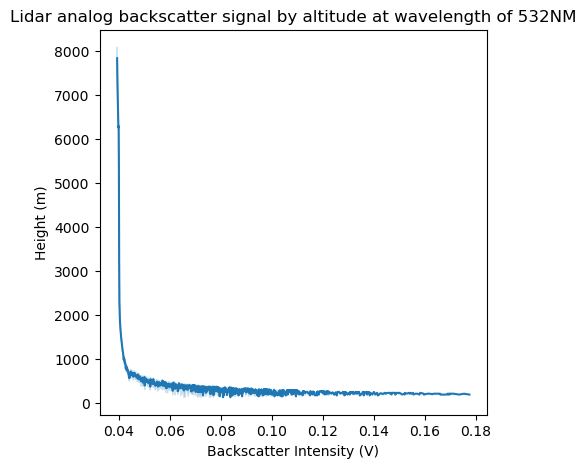

In [ ]:
plt.figure(figsize = (5, 5))
sns.lineplot(x = analog['backscatter_intensity_532NM'], y = analog['range'])
plt.xlabel('Backscatter Intensity (V)')
plt.ylabel('Height (m)')
plt.title('Lidar analog backscatter signal by altitude at wavelength of 532NM')
plt.show()

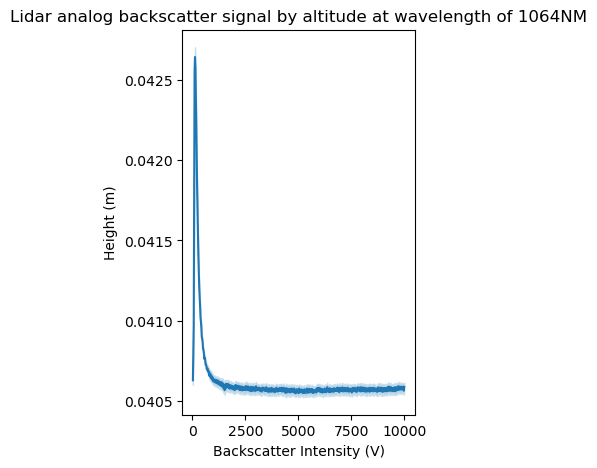

In [ ]:
# and for the 1064 nm wavelength
plt.figure(figsize = (3, 5))
sns.lineplot(x = analog['backscatter_intensity_1064NM'], y = analog['range'])
plt.xlabel('Backscatter Intensity (V)')
plt.ylabel('Height (m)')
plt.title('Lidar analog backscatter signal by altitude at wavelength of 1064NM')
plt.show()

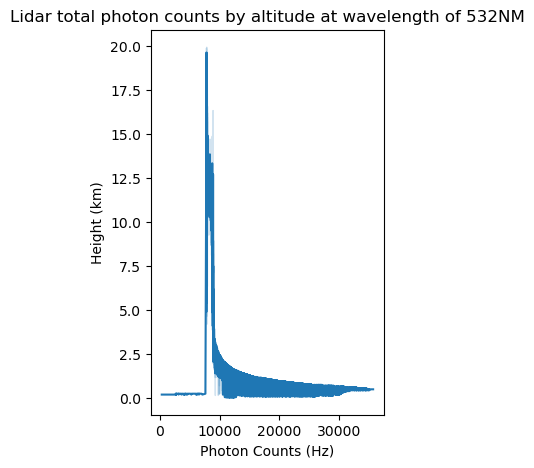

In [20]:
# and now for the photon counts 

plt.figure(figsize = (3, 5))
sns.lineplot(x = photon['total_photon_counts_532NM'], y = photon['range']/1000)
plt.xlabel('Photon Counts (Hz)')
plt.ylabel('Height (km)')
plt.title('Lidar total photon counts by altitude at wavelength of 532NM')
plt.show()

Analog Counting is typically used a shorter altitude ranges than what was recorded, so it may also be useful to look at the backscatter intensity compared to shorter ranges. 

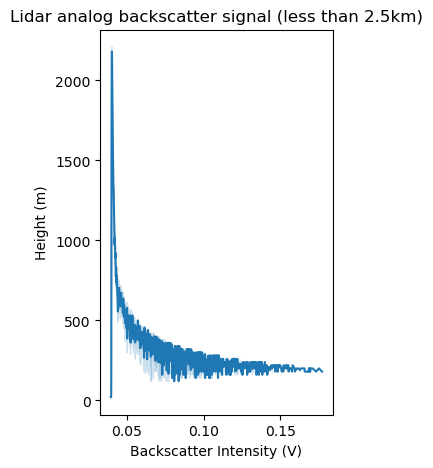

In [31]:
plt.figure(figsize = (3, 5))
sns.lineplot(x = analog.query('range < 2500')['backscatter_intensity_532NM'], y = analog.query('range < 2500')['range'])
plt.xlabel('Backscatter Intensity (V)')
plt.ylabel('Height (m)')
plt.title('Lidar analog backscatter signal (less than 2.5km)')
plt.show()

##### 5. Exploring Pressure / Temperature 

Similarily to the Lidar data, I will be working with the reduced data only for this tutorial. 

The reduced data record for P/T contains 4 different datasets, all with times converted into earth seconds, and the altitude ranges in metres

- RMA is RDR Ancillary Data - it contains non-corrected pressure & temperature data and as such is not the best for analysis, known mostly as "housekeeping" data, it is kept for record keeping.

- RMC is RDR Corrected Data - it contains corrected pressure values, which account for the heat radiated by the instrument itself 

- RML is Low Resolution RDR data - contains average, standard deviations, min and max temperatures at 3 altitudes (250m, 500m, and 1000m) every 512 earth seconds. 

- RMH is High Resolution RDR data - entries are collected either by an averaging mode (meaning either a temperature event of a change of 15 Kelvin over 512 seconds or a pressure event of a 1 Pascal pressure difference over 512 seconds) or when the min & max values of temperature at a time exceed the 'trigger' aka a pre-set threshold. 

In this tutorial we will focues on the RMC.

For more information such as the start times, column names and units, you can access the label files (LBL) from the directory.

In [ ]:

corrected = pd.read_csv('Downloads/test_folder/MS065RMC_00901976517_1761M1.TAB.csv', header=None)
highmet = pd.read_csv('Downloads/test_folder/MS065RMH_00901976517_1761M1.TAB.csv', header=None)
lowmet = pd.read_csv('Downloads/test_folder/MS065RML_00901976517_1761M1.TAB.csv', header=None)

corrected.columns = ['Time', 'Pressure', '250_Temperature', '500_Temperature', '1000_Temperature', 'Ref_Temperature']
lowmet.columns = ["Time", "Pressure_Avg", "Pressure_Stdev", "Pressure_Min", "Pressure_Max",
                   "250_Temperature_Avg", "250_Temperature_Stdev", "250_Temperature_Min", "250_Temperature_Max",
                     "500_Temperature_Avg", "500_Temperature_Stdev", "500_Temperature_Min", "500_Temperature_Max",
                     "1000_Temperature_Avg", "1000_Temperature_Stdev", "1000_Temperature_Min", "1000_Temperature_Max", 
                     "Ref_Temperature_Avg", "Ref_Temperature_Stdev", "Ref_Temperature_Min", "Ref_Temperature_Max",
                     "Trigger_Sensor"]
highmet.columns = ["Time", "Pressure", "250_Temperature", "500_Temperature", "1000_Temperature", "Reference_Temperature"]

##### Temperature Variations at Different Altitudes

The MET Instrument had a mast at three different heights (250mm, 500mm, and 1000mm) and measured the surrounding temperature at each.
Here's a sample visualization for comparing these three heights, along with the reference temperature

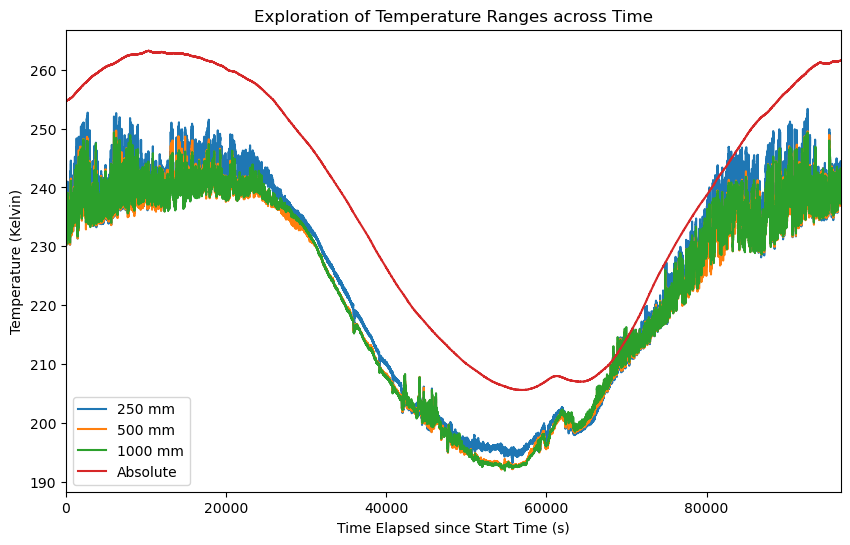

In [ ]:
# let's look at  temperature variations at the different altitudes 
plt.figure(figsize = (10, 6))
plt.plot(corrected['Time'], corrected['250_Temperature'], label='250 mm')
plt.plot(corrected['Time'], corrected['500_Temperature'], label='500 mm')
plt.plot(corrected['Time'], corrected['1000_Temperature'], label='1000 mm')
plt.plot(corrected['Time'], corrected['Ref_Temperature'], label='Absolute')

plt.legend()
plt.title('Exploration of Temperature Ranges across Time')
plt.xlabel('Time Elapsed since Start Time (s)')
plt.ylabel('Temperature (Kelvin)')
plt.margins(x=0)
plt.show()

##### Relationship between pressure & temperature at varying heights

Pressure was also recorded by this instrument, so below is a visualization exploring the relationship between it and the temperatures recorded. See if you can observe a general trend. 

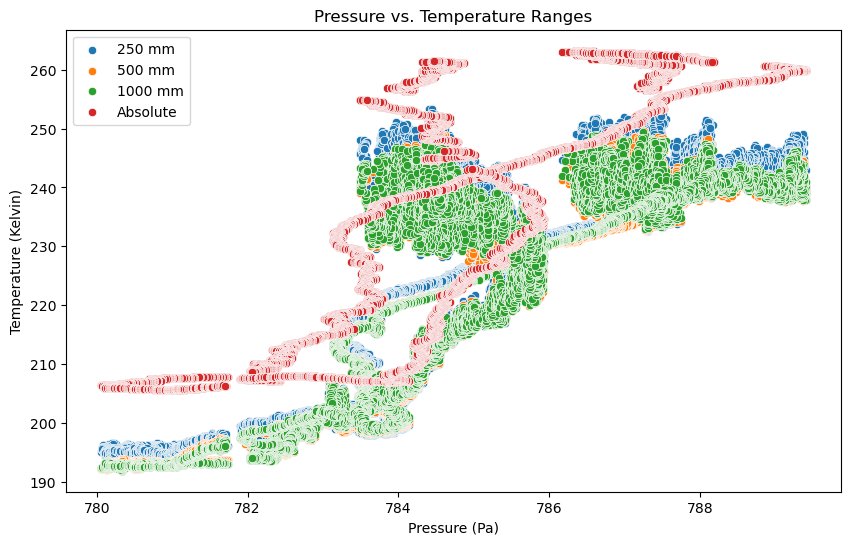

In [7]:
# correlation between pressure & temperature 

pressure_over_0 = corrected.query('Pressure > 0')['Pressure']

plt.figure(figsize = (10, 6))
sns.scatterplot(x = pressure_over_0,  y = corrected['250_Temperature'], label='250 mm')
sns.scatterplot(x = pressure_over_0, y = corrected['500_Temperature'], label='500 mm')
sns.scatterplot(x = pressure_over_0, y = corrected['1000_Temperature'], label='1000 mm')
sns.scatterplot(x = pressure_over_0, y = corrected['Ref_Temperature'], label='Absolute')

plt.legend()
plt.title('Pressure vs. Temperature Ranges')
plt.xlabel('Pressure (Pa)')
plt.ylabel('Temperature (Kelvin)')
plt.show()